# FEC Analysis

## Objectives
1. Identify a suitable threshold for binarizing
2. Identify a suitable threshold for Conditioned Response

## Approach for identifying threshold
1. Blur ROI using 3x3 average filters to avoid salt and pepper like single pixel noise
2. Plot histogram of the intensities of the blurred roi
3. Use a gaussian filter to smoothen over the histogram
4. Identify 'inflection_points' as the intensity at whicch the curve is about to switch from negative slope to positive slope
5. Steps 1-4 are repeated for all frames in the 'PRE' period. The median inflection point is chosen as the threshold for binarizing all frames within a trial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import cv2
from scipy.ndimage import gaussian_filter1d
import math
import glob
from sklearn import mixture
from scipy.optimize import curve_fit
%matplotlib notebook
from scipy import signal, fft

In [64]:
mouse_name = "G405"
session_code = "SoAn1"
session_upi = 4
path = "/home1/bhalla/hrishikeshn/"
file_name = path + "BehaviorRawData/" + mouse_name + "/" + mouse_name + "_" + session_code + "_" + str(session_upi) + "/021.tiff"
csv_file = "../csv/" + mouse_name + ".csv"
#roi = (375, 95, 405, 245)
sigma_gauss_filter = 0.75  # standard deviation of gaussian filter
n_bins = 70  # number of bins for intensity histogram

In [65]:
def get_roi(csvfile, session_upi):
    csv_data = pd.read_csv(csv_file, delimiter=",", dtype={
                'upi': int,
                'xmin:ymin': str,
                'xmax:ymax': str,
            },)
    xmin, ymin = [int(i) for i in csv_data.loc[csv_data["upi"]==session_upi, "xmin:ymin"].iloc[0].split(":")]
    xmax, ymax = [int(i) for i in csv_data.loc[csv_data["upi"]==session_upi, "xmax:ymax"].iloc[0].split(":")]
    print(xmin, ymin, xmax, ymax)
    return (xmin, ymin, xmax, ymax)

In [66]:
roi = get_roi(csv_file, session_upi)
# roi = (365, 120, 395, 220)

375 105 405 255


In [67]:
def get_threshold(frame_stack, roi):
    x_min, y_min, x_max, y_max = roi
    inflection_points = []

    for f, frame in enumerate(frame_stack):
        bin_line = frame[0, :]
        data_line = ("".join(([chr(x) for x in bin_line]))).rstrip()
        tokens = data_line.split(",")

        if tokens[10] == "PRE_":
            eye_roi = frame[y_min:y_max, x_min:x_max]
            blurred_roi = cv2.blur(eye_roi, (3, 3))
            bins = np.linspace(0, 255, n_bins)
            counts, bins = np.histogram(blurred_roi, bins=bins, density=True)
            smoothed_counts = gaussian_filter1d(counts, sigma_gauss_filter)
            smoothed_d1 = np.gradient(smoothed_counts)
            inflection_point_indices = np.where(np.diff(np.sign(smoothed_d1)) > 1.5)[0]
            if np.any(inflection_point_indices):
                inflection_points.append(bins[inflection_point_indices[0]])
            else:
                inflection_points.append(np.nan)

        else:
            break

    threshold = np.nanmedian(inflection_points)
    if math.isnan(threshold):
        print("Obtained Nan value for binarizing threshold")
    return threshold

In [68]:
def get_threshold_median(frame_stack, roi):
    x_min, y_min, x_max, y_max = roi
    inflection_points = []

    for f, frame in enumerate(frame_stack):
        bin_line = frame[0, :]
        data_line = ("".join(([chr(x) for x in bin_line]))).rstrip()
        tokens = data_line.split(",")

        if tokens[10] == "PRE_":
            eye_roi = frame[y_min:y_max, x_min:x_max]
            blurred_roi = cv2.medianBlur(eye_roi, 5)
            bins = np.linspace(0, 255, n_bins)
            counts, bins = np.histogram(blurred_roi.flatten(), bins=bins, density=True)
            smoothed_counts = gaussian_filter1d(counts, sigma_gauss_filter)
            smoothed_d1 = np.gradient(smoothed_counts)
            inflection_point_indices = np.where(np.diff(np.sign(smoothed_d1)) > 1.5)[0]
            if np.any(inflection_point_indices):
                inflection_points.append(bins[inflection_point_indices[0]])
            else:
                inflection_points.append(np.nan)

        else:
            break

    threshold = np.nanmedian(inflection_points)
    if math.isnan(threshold):
        print("Obtained Nan value for binarizing threshold")
    return threshold

In [69]:
def get_threshold_gauss(frame_stack, roi):
    x_min, y_min, x_max, y_max = roi
    inflection_points = []

    for f, frame in enumerate(frame_stack):
        bin_line = frame[0, :]
        data_line = ("".join(([chr(x) for x in bin_line]))).rstrip()
        tokens = data_line.split(",")

        if tokens[10] == "PRE_":
            eye_roi = frame[y_min:y_max, x_min:x_max]
            blurred_roi = cv2.blur(eye_roi, (3, 3))
            bins = np.linspace(0, 255, n_bins)
            counts, bins = np.histogram(blurred_roi.flatten(), bins=bins, density=True)
            smoothed_counts = gaussian_filter1d(counts, sigma_gauss_filter)
            smoothed_d1 = np.gradient(smoothed_counts)
            inflection_point_indices = np.where(np.diff(np.sign(smoothed_d1)) > 1.5)[0]
            if np.any(inflection_point_indices):
                inflection_points.append(bins[inflection_point_indices[0]])
            else:
                inflection_points.append(np.nan)

        else:
            break

    threshold = np.nanmedian(inflection_points)
    if math.isnan(threshold):
        print("Obtained Nan value for binarizing threshold")
    return threshold

In [70]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


In [71]:
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

In [72]:
def plot_images(frame_stack, roi, threshold):
    x_min, y_min, x_max, y_max = roi

    for f, frame in enumerate(frame_stack):
        if f % 50 == 0:
            eye_roi = frame[y_min:y_max, x_min:x_max]
#             flattened_blurred_roi = blurred_roi.flatten()

            bins = np.linspace(0, 255, n_bins)
#             counts, bins = np.histogram(blurred_roi, bins=bins, density=True)
#             smoothed_counts = gaussian_filter1d(counts, sigma_gauss_filter)
#             cum_counts = np.cumsum(counts) * (bins[1] - bins[0])
            
            fig = plt.figure(figsize=(7, 6))
            plt.suptitle(f"frame #{f}")
            spec = fig.add_gridspec(2, 10)

            axa = fig.add_subplot(spec[0, 0:2])
            axa.imshow(eye_roi, cmap="gray")
            axa.set_title("original")

            blurred_roi = cv2.blur(eye_roi, (3,3))
            binarized_roi = blurred_roi > threshold
            axb = fig.add_subplot(spec[0, 2:4])
            axb.imshow(blurred_roi, cmap="gray")
            axb.set_title("blurred")

#             axc = fig.add_subplot(spec[0, 4:6])
            
            axd = fig.add_subplot(spec[0, 4:6])
#             sos = signal.butter(6, 0.5, 'lp', output='sos')
#             filtered = signal.sosfilt(sos, eye_roi)
#             axd.imshow(filtered, cmap="gray")
#             axd.set_title("butterworth")
            
#             axe = fig.add_subplot(spec[0, 6:8])
#             ft = calculate_2dft(eye_roi)
#             axe.imshow(np.log(np.abs(ft)), cmap="gray")
#             axe.set_title("fft")
            
#             axf = fig.add_subplot(spec[0, 8:10])
            median_filtered = cv2.medianBlur(eye_roi, 5)
            axd.imshow(median_filtered, cmap="gray")
            axd.set_title("median_filtered")
            
            axe = fig.add_subplot(spec[0, 6:8])
            axe.imshow(binarized_roi, cmap="gray")
            axe.set_title("binarized")
            
            
            median_blurred_roi = cv2.medianBlur(eye_roi, 5)
            median_binarized_roi = median_blurred_roi > threshold
            axf = fig.add_subplot(spec[0, 8:10])
            axf.imshow(median_binarized_roi, cmap="gray")
            axf.set_title("median binarized")
            
            axg = fig.add_subplot(spec[1, 0:4])
            h1, bins, _ = axg.hist(blurred_roi.flatten(), bins=bins, density=True)
            axg.axvline(threshold, color="r", label="threshold")
            
            axh = fig.add_subplot(spec[1, 4:8])
            h2, bins, _ = axh.hist(median_filtered.flatten(), bins=bins, density=True)
            axh.axvline(threshold, color="r", label="threshold")
            

#             axd = fig.add_subplot(spec[1, 0:3])
#             print(flattened_blurred_roi.shape)
#             h1, bins, _ = axd.hist(flattened_blurred_roi, bins=bins, density=True)
#             mid_points = (bins[0:-1] + bins[1:])/2
#             print(h1.shape)
#             expected=(25,10,100,115,50,75)
#             params,cov=curve_fit(bimodal, mid_points, h1, expected)
#             sigma=np.sqrt(np.diag(cov))
#             curve = bimodal(mid_points,*params)
#             axd.plot(mid_points, curve, color='k',label='model')
#             #axd.plot(mid_points, gauss(mid_points, *params[:3]), color='c',label='g1')
#             #axd.plot(mid_points, gauss(mid_points, *params[3:]), color='c',label='g2')
#             print(curve)
#             grad = np.gradient(curve)
#             print(grad)
#             print(np.sign(grad))
#             print(np.diff(np.sign(grad)))
#             inflec_point = np.where(np.diff(np.sign(grad)) > 1.5)[0]
#             print(inflec_point)
            

#             axd = fig.add_subplot(spec[1, 0:3])
#             print(flattened_blurred_roi.shape)
#             h1, bins, _ = axd.hist(flattened_blurred_roi, bins=bins, density=True)
#             mid_points = (bins[0:-1] + bins[1:])/2
#             print(h1.shape)
#             expected=(25,10,100,115,50,75)
#             params,cov=curve_fit(bimodal, mid_points, h1, expected)
#             sigma=np.sqrt(np.diag(cov))
#             curve = bimodal(mid_points,*params)
#             axd.plot(mid_points, curve, color='k',label='model')
#             #axd.plot(mid_points, gauss(mid_points, *params[:3]), color='c',label='g1')
#             #axd.plot(mid_points, gauss(mid_points, *params[3:]), color='c',label='g2')
#             print(curve)
#             grad = np.gradient(curve)
#             print(grad)
#             print(np.sign(grad))
#             print(np.diff(np.sign(grad)))
#             inflec_point = np.where(np.diff(np.sign(grad)) > 1.5)[0]
#             print(inflec_point)
#             axd.axvline(mid_points[inflec_point], color="k", ls="--", label="inflec_point")
            

            #axd.plot(bins[1:], smoothed_counts, label="gaussian smoothening")
#             axd.axvline(threshold, color="r", label="threshold")
#             axd.set_xlabel("intensity")
#             axd.set_ylabel("probability")
#             axd.set_title("blurred")
#             axd.legend()

#             axe = fig.add_subplot(spec[1, 3:6])
#             axe.plot(bins[1:], cum_counts)
#             axe.axvline(threshold, color="r", label="threshold")
#             axe.set_xlabel("intensity")
#             axe.set_ylabel("cumulative probability")
#             axe.set_title("blurred")
#             axe.legend()

70.21739130434783 51.73913043478261 70.21739130434783


<IPython.core.display.Javascript object>


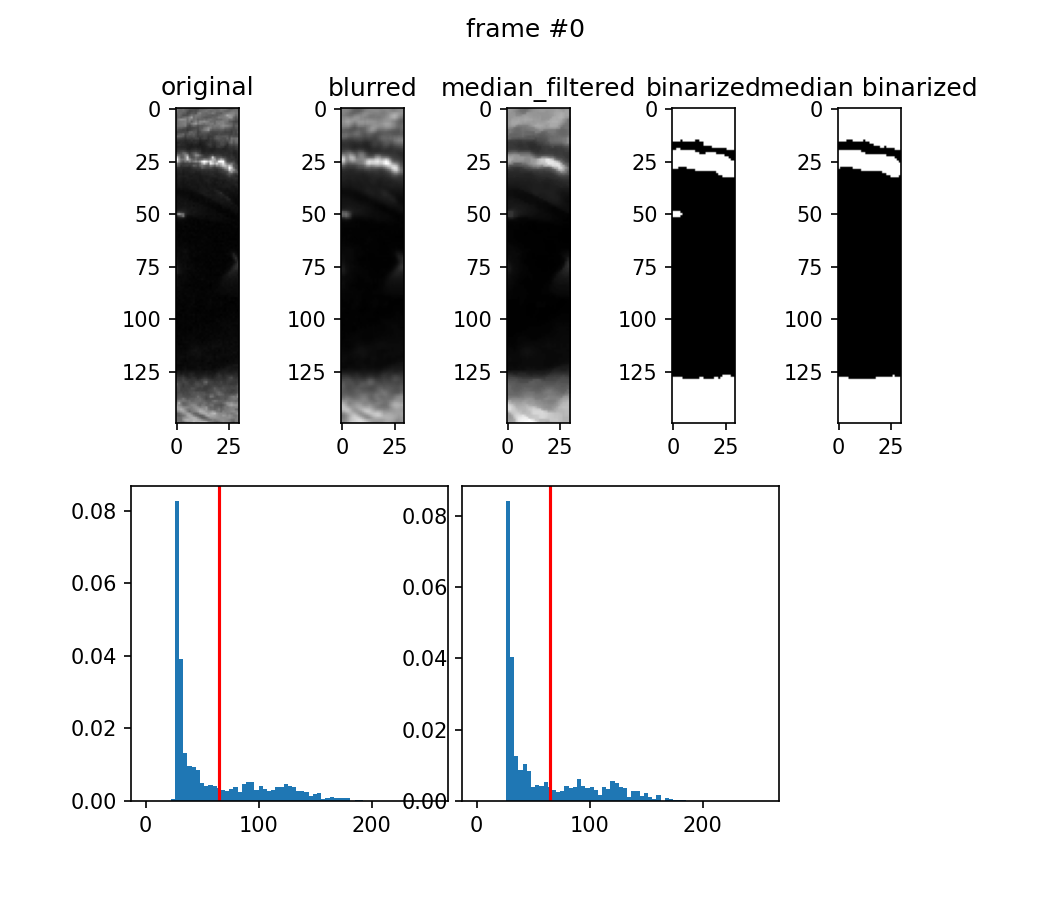

<IPython.core.display.Javascript object>


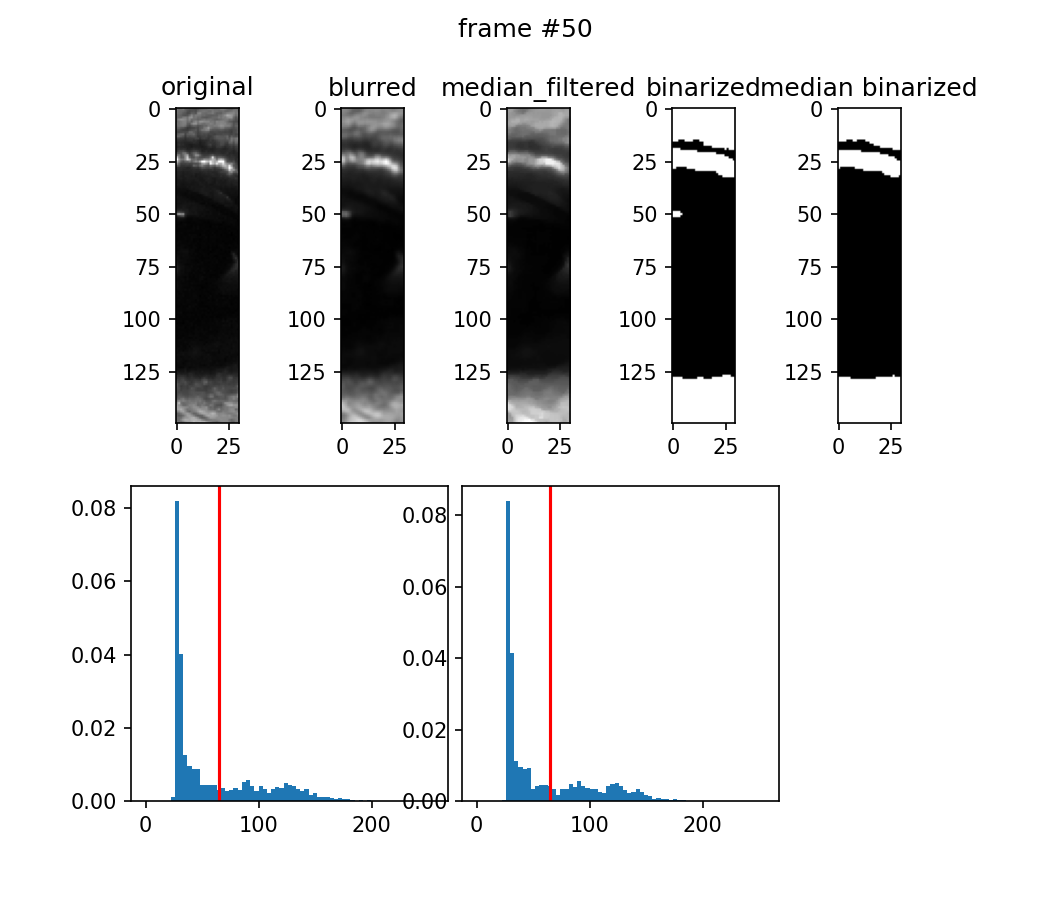

<IPython.core.display.Javascript object>


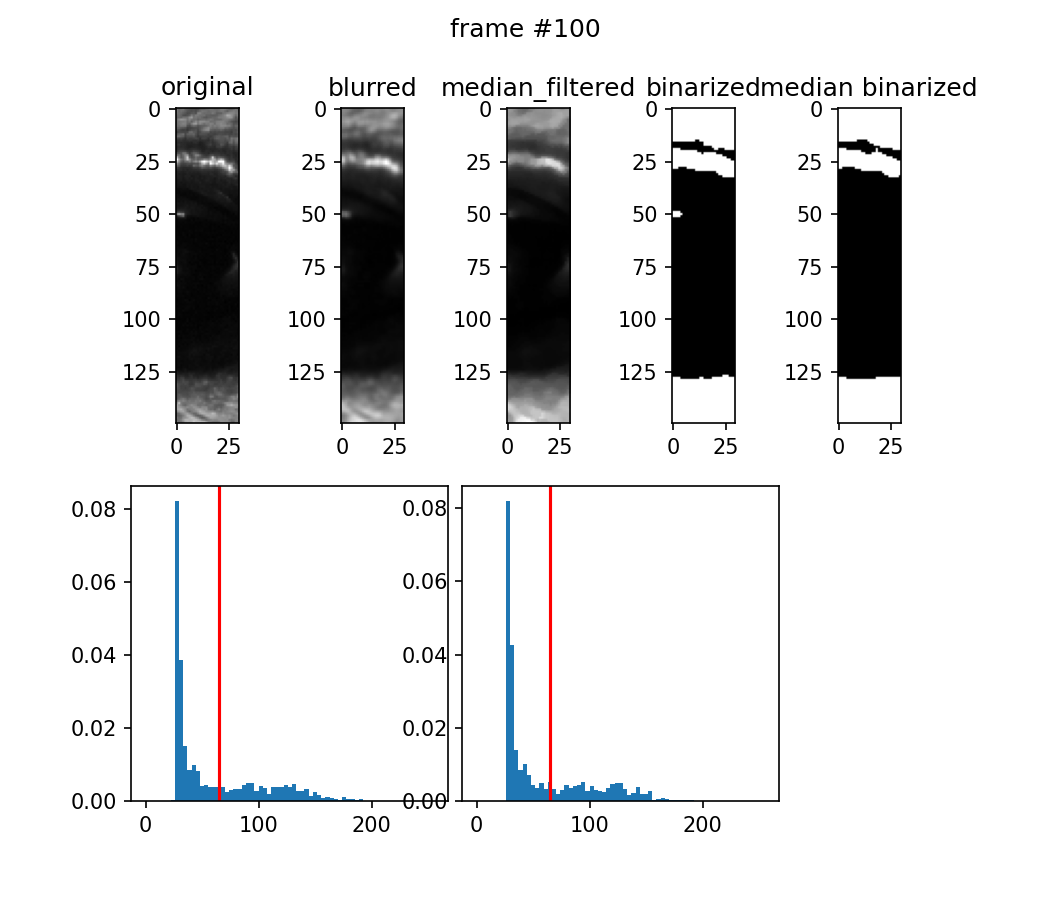

<IPython.core.display.Javascript object>


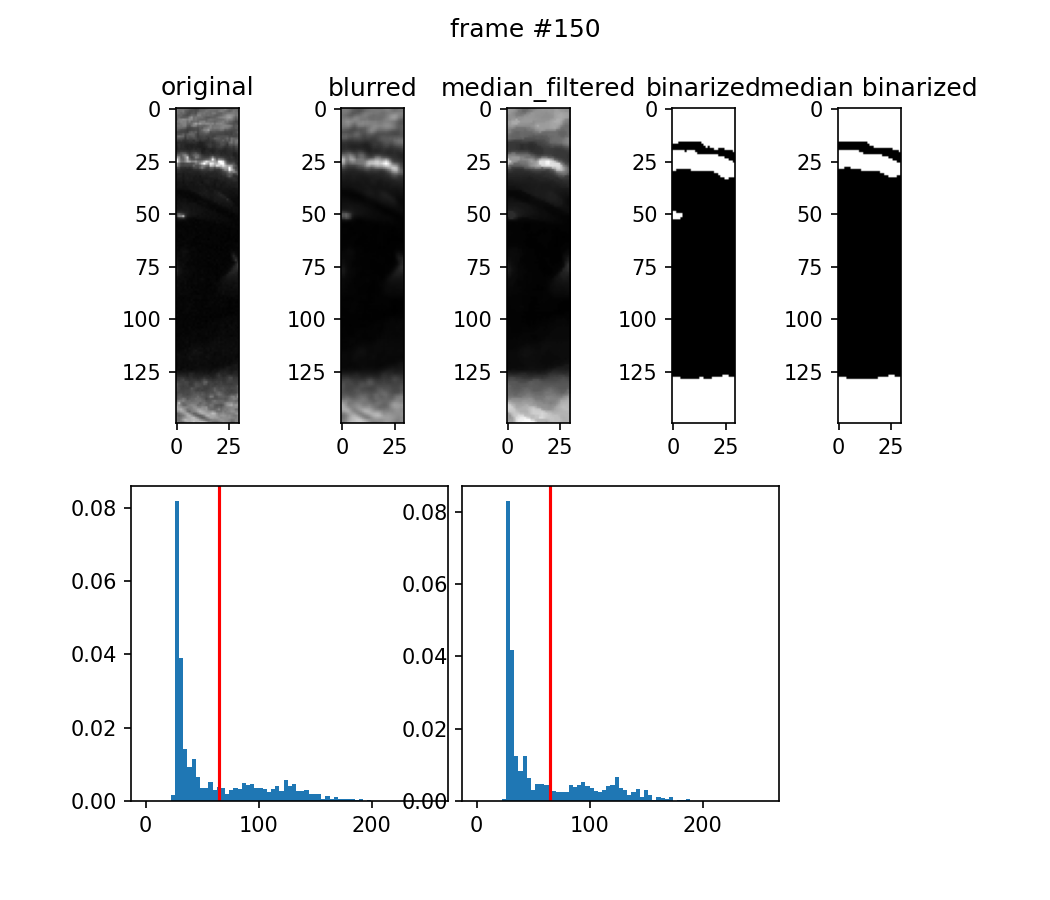

<IPython.core.display.Javascript object>


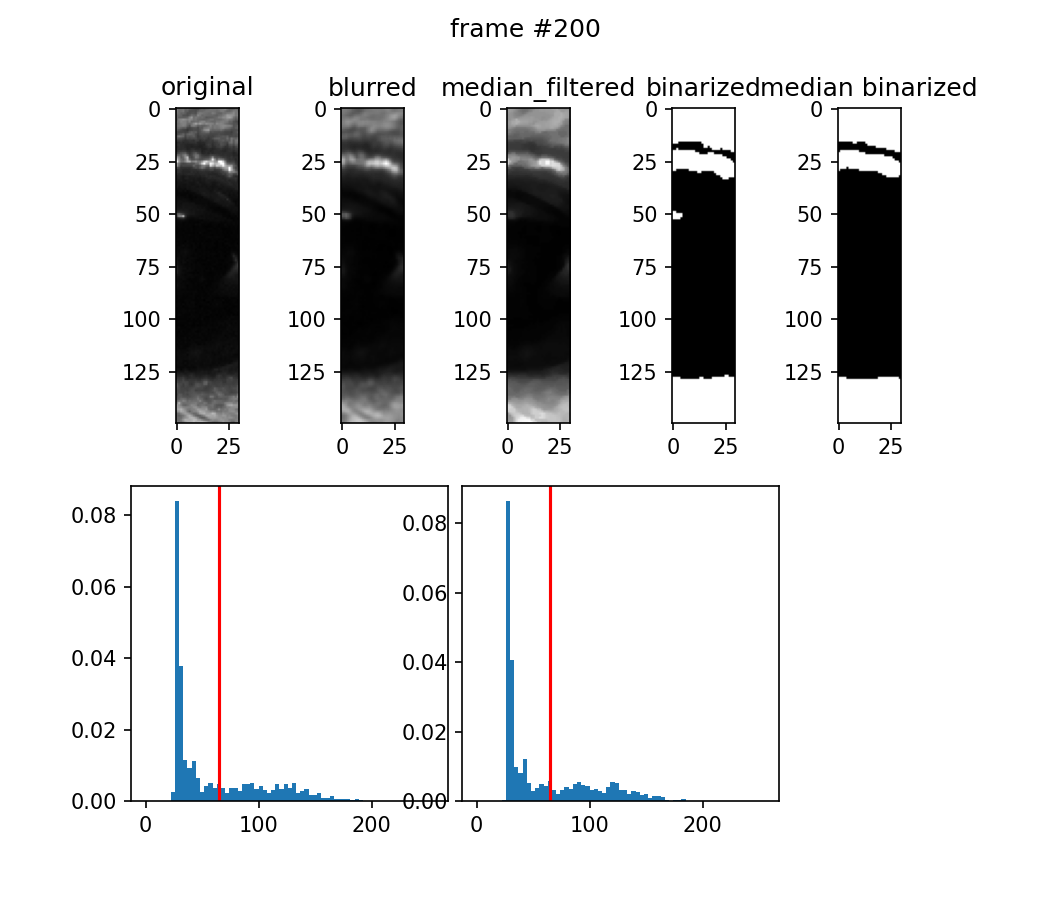

<IPython.core.display.Javascript object>


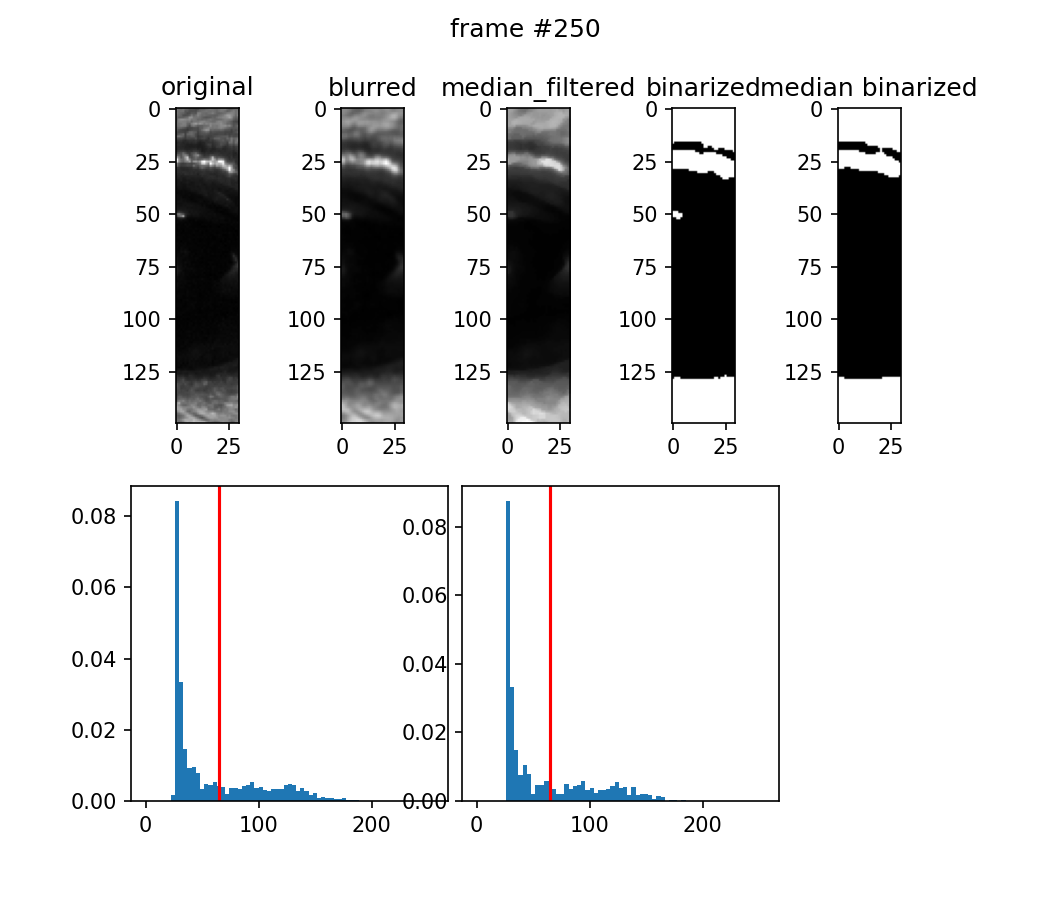

<IPython.core.display.Javascript object>


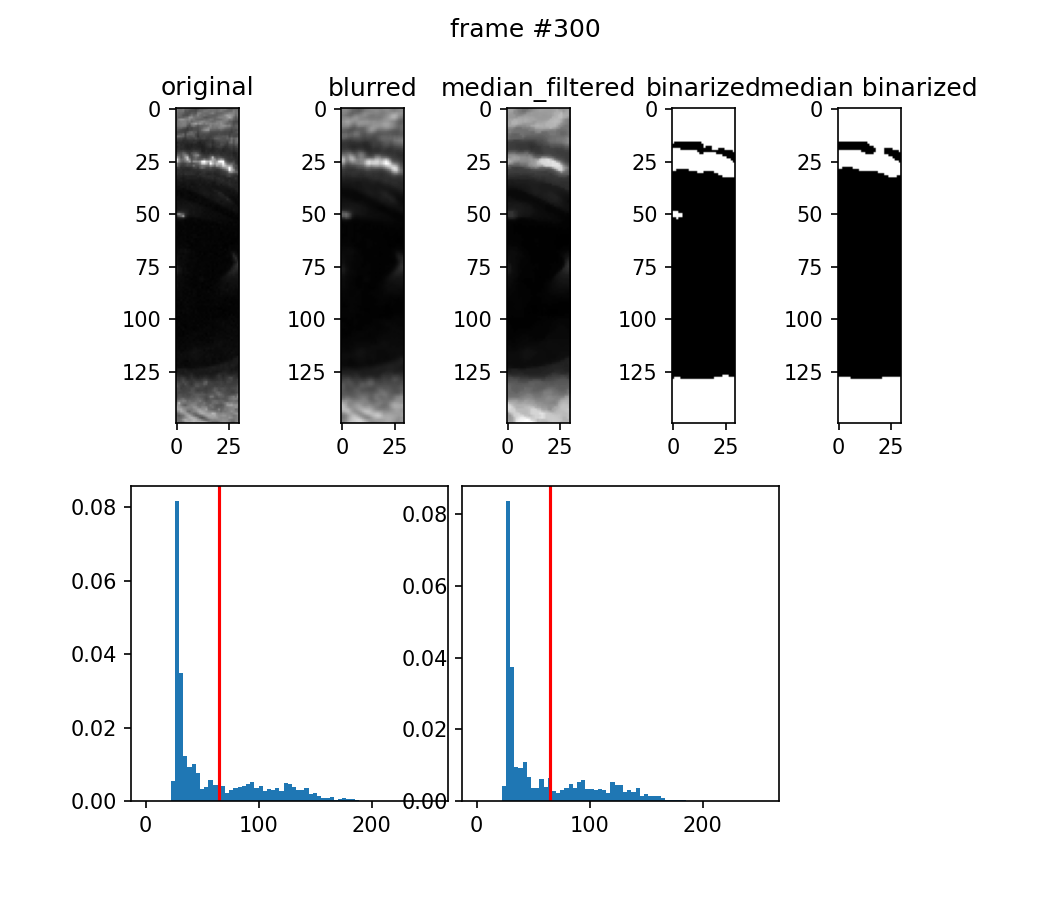

<IPython.core.display.Javascript object>


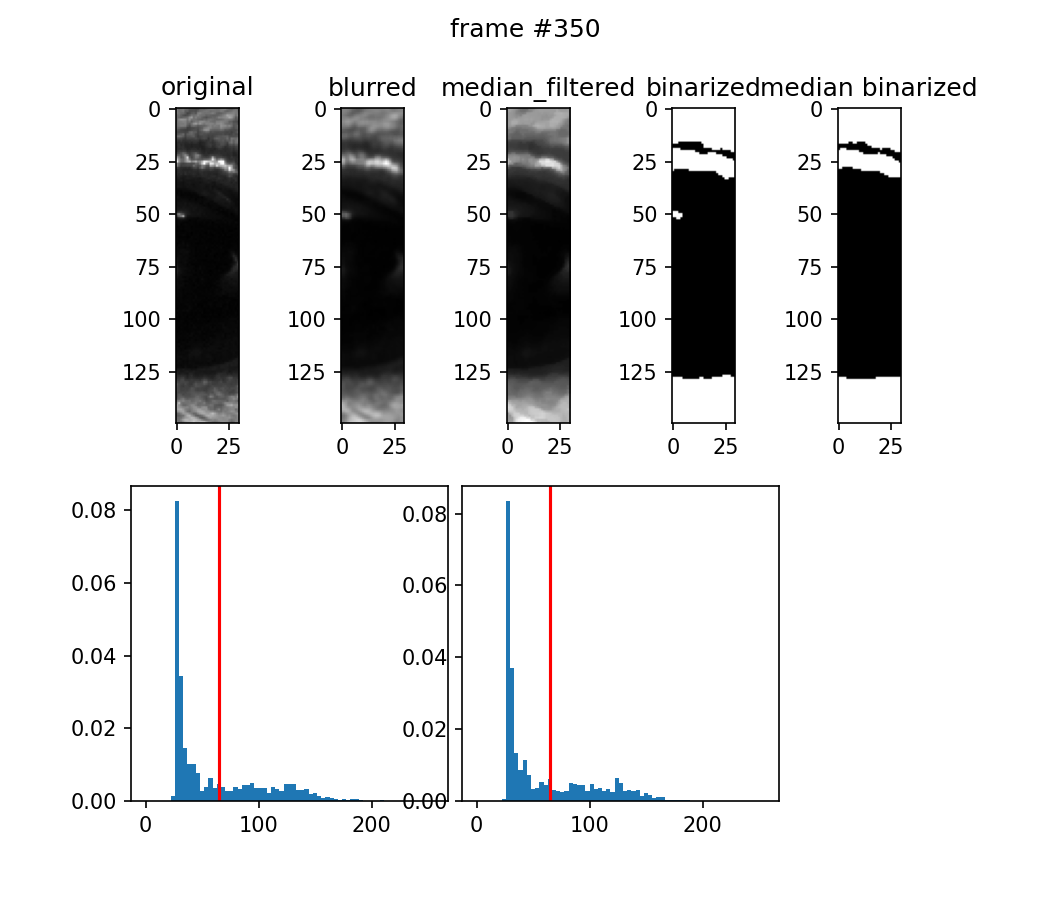

<IPython.core.display.Javascript object>


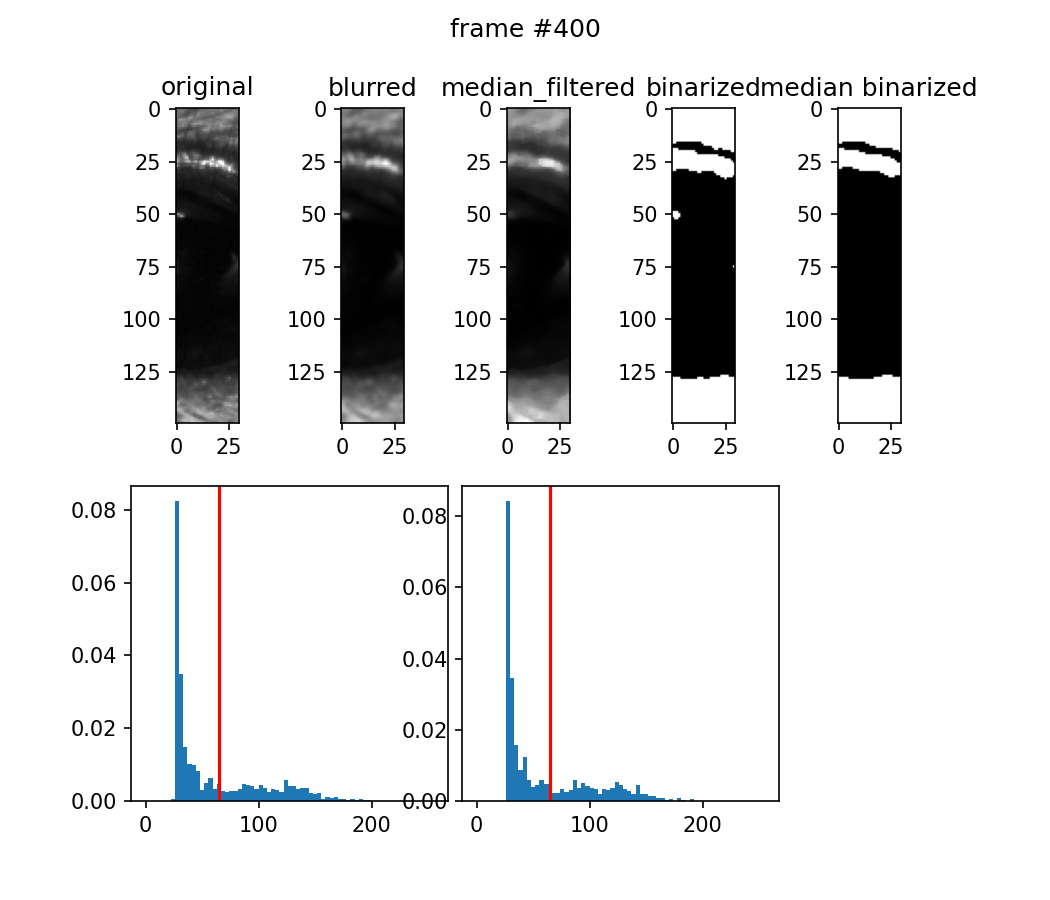

<IPython.core.display.Javascript object>


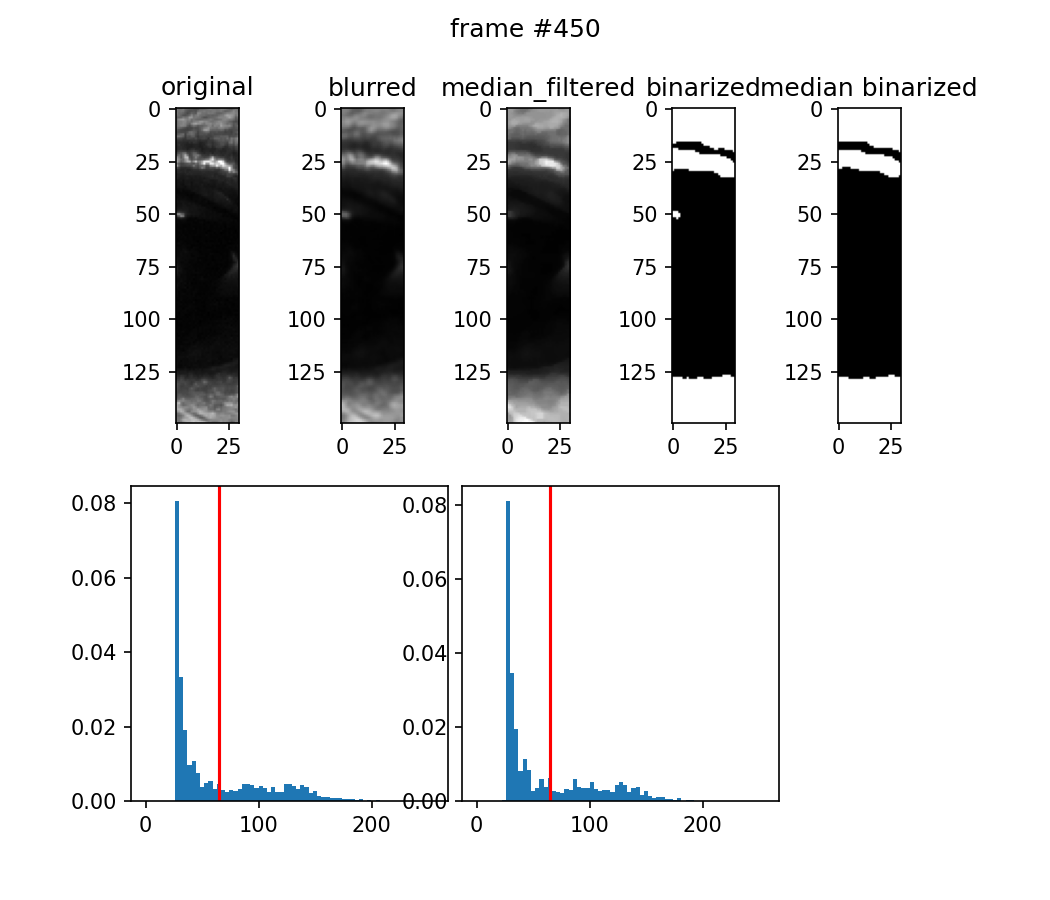

<IPython.core.display.Javascript object>


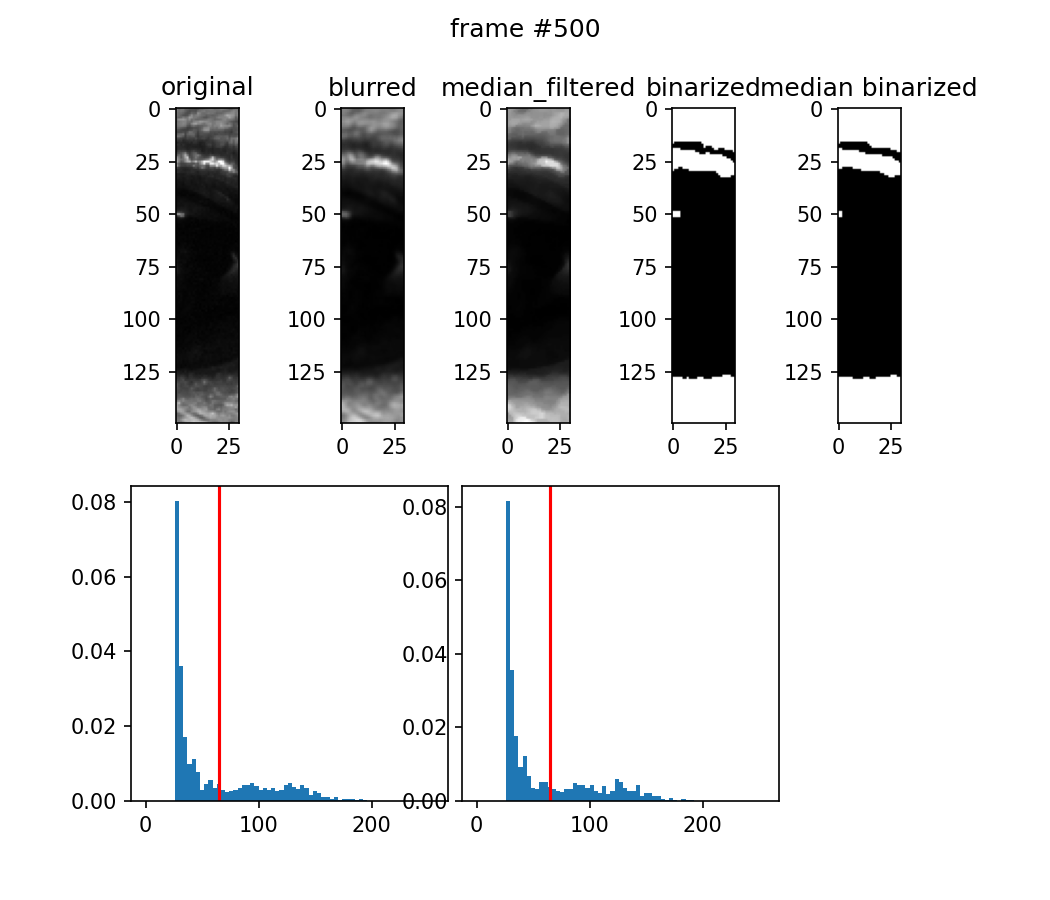

<IPython.core.display.Javascript object>


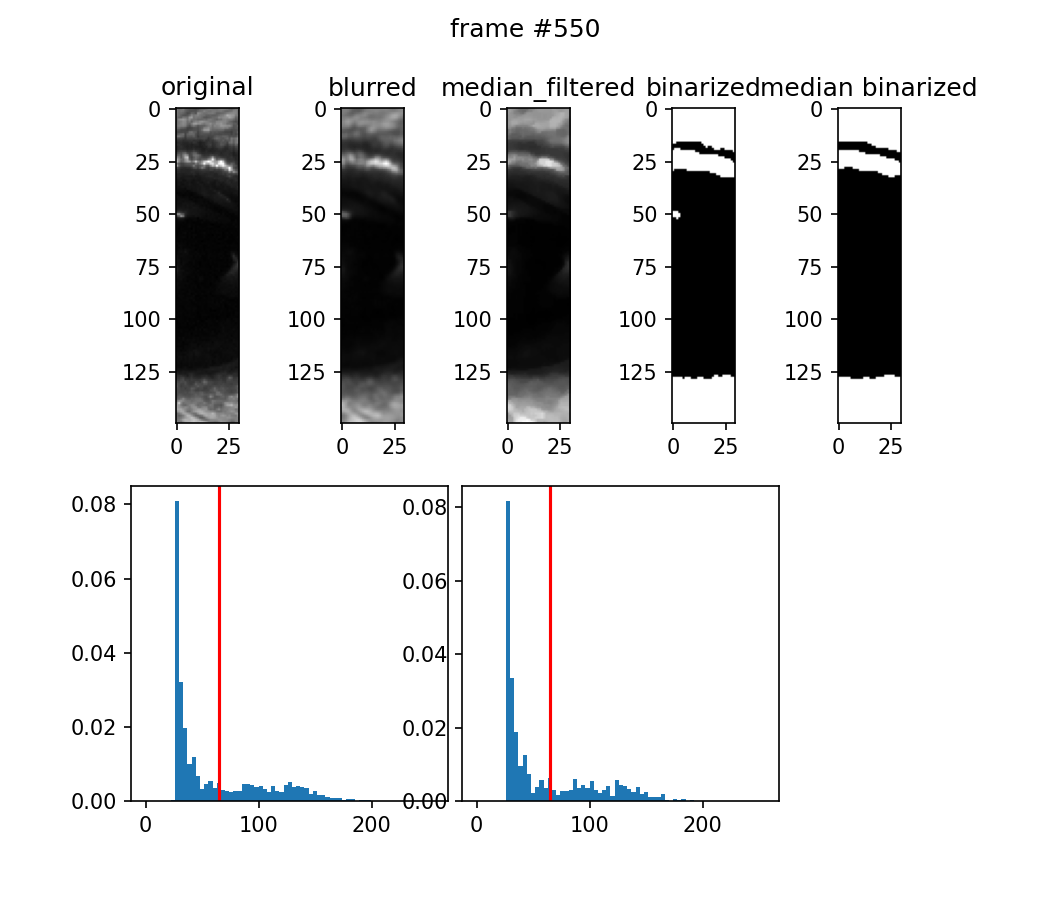

<IPython.core.display.Javascript object>


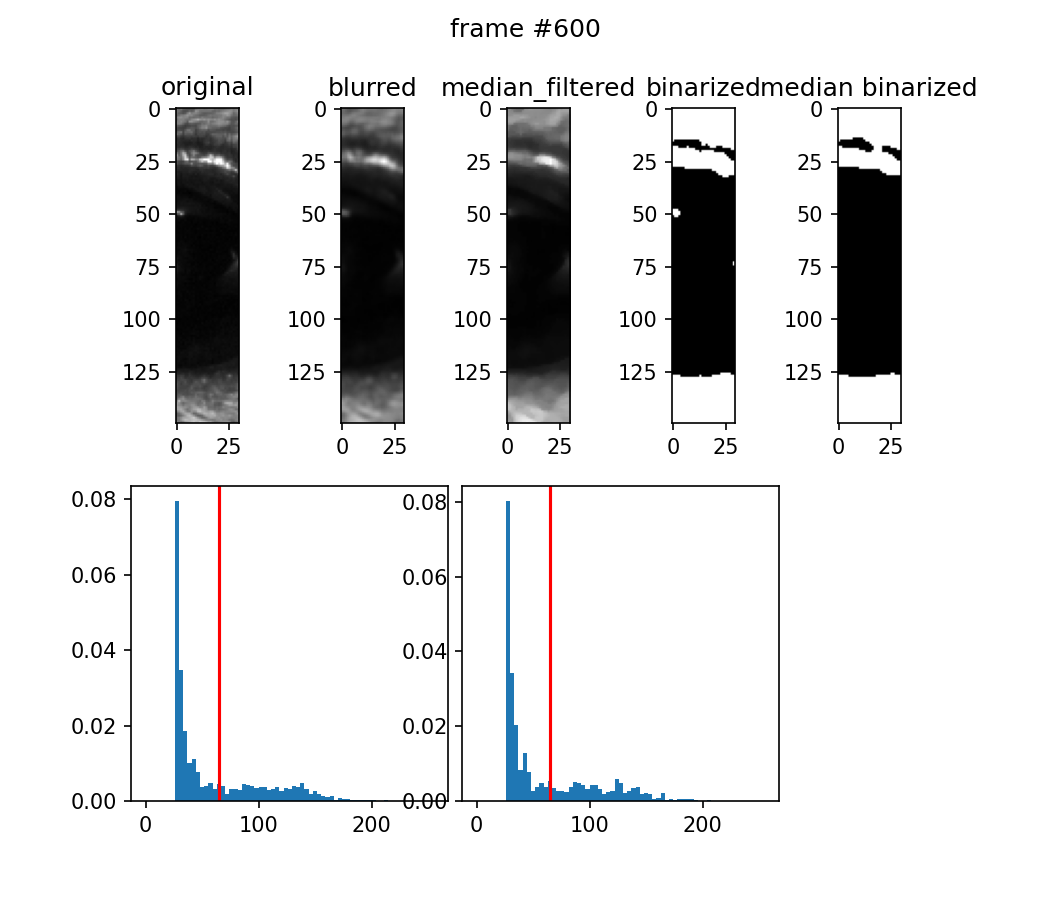

<IPython.core.display.Javascript object>


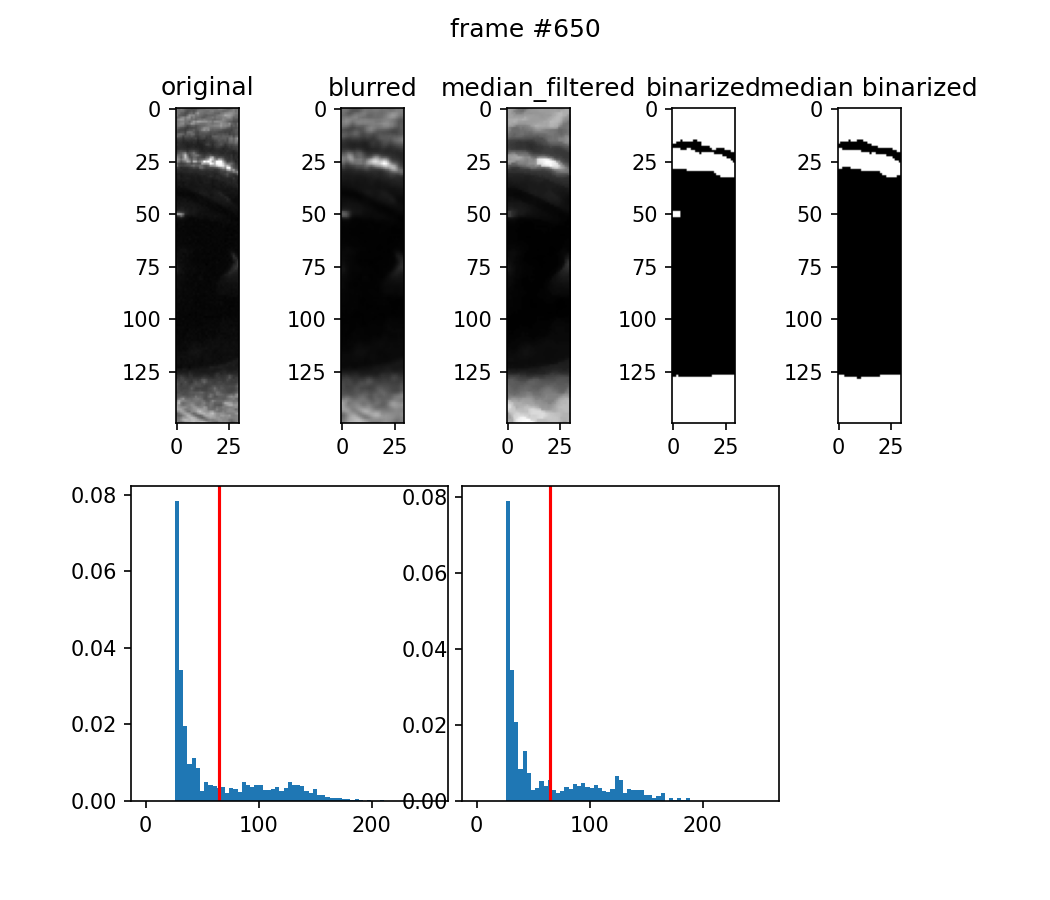

In [73]:
frame_stack = io.imread(file_name)
threshold1 = get_threshold(frame_stack, roi)
threshold2 = get_threshold_median(frame_stack, roi)
threshold3 = get_threshold_gauss(frame_stack, roi)
print(threshold1, threshold2, threshold3)
threshold2 = 65
plot_images(frame_stack, roi, threshold2)

## FEC Logic
1. eye_openness = #black pixels in binarized ROI
2. Identify max_eye_openness from the frame with the max number of black pixels the PRE period
3. FEC = 1 - (#eye_openness/ max_eye_openness)

In [ ]:
def get_max_eye_openness(frame_stack, roi, threshold):
    x_min, y_min, x_max, y_max = roi
    max_eye_openness = 0

    for f, frame in enumerate(frame_stack):
        bin_line = frame[0, :]
        data_line = ("".join(([chr(x) for x in bin_line]))).rstrip()
        tokens = data_line.split(",")

        if tokens[10] == "PRE_":
            eye_roi = frame[y_min:y_max, x_min:x_max]
            blurred_roi = cv2.blur(eye_roi, (3, 3))
            binarized_roi = blurred_roi > threshold
            max_eye_openness = max(max_eye_openness, np.sum(~binarized_roi))

    return max_eye_openness

In [18]:
def plot_fec(path, roi):
    x_min, y_min, x_max, y_max = roi

    fig = plt.figure(figsize=(7, 3))
    spec = fig.add_gridspec(1, 2)
    axa = fig.add_subplot(spec[0, 0])
    axb = fig.add_subplot(spec[0, 1])

    fec_traces = []
    cs_frames = []
    us_frames = []
    probe_trials = []

    for t, trial_video in enumerate(sorted(glob.glob(path + "/*.ti*"))):
        # if t == 23:
        #     break

        frame_stack = io.imread(trial_video)

        fec = np.zeros(frame_stack.shape[0])

        threshold = get_threshold(frame_stack, roi)
        max_eye_openness = get_max_eye_openness(frame_stack, roi, threshold)
        prev_token = "PRE_"
        cs_start = np.NaN
        cs_end = np.NaN
        us_start = np.NaN
        us_end = np.NaN
        probe_flag = False

        for f, frame in enumerate(frame_stack):
            bin_line = frame[0, :]
            data_line = ("".join(([chr(x) for x in bin_line]))).rstrip()
            curr_token = data_line.split(",")[10]
            if prev_token == "PRE_" and curr_token == "CS+":
                cs_start = f
            if prev_token == "CS+" and curr_token == "TRAC":
                cs_end = f - 1
            elif prev_token == "TRAC" and (
                curr_token == "PUFF" or curr_token == "PROB"
            ):
                us_start = f
            elif (
                prev_token == "PUFF" or prev_token == "PROB"
            ) and curr_token == "POST":
                us_end = f - 1
            if curr_token == "PROB":
                probe_flag = True

            eye_roi = frame[y_min:y_max, x_min:x_max]
            blurred_roi = cv2.blur(eye_roi, (3, 3))
            binarized_roi = blurred_roi > threshold
            fec[f] = 1 - (np.sum(~binarized_roi) / max_eye_openness)

            prev_token = curr_token

        fec_traces.append(fec)
        cs_frames.append([cs_start, cs_end])
        us_frames.append([us_start, us_end])
        probe_trials.append(probe_flag)

        # axa.plot(np.arange(len(fec)), fec, c="b", alpha=0.5)
        # if ~math.isnan(cs_start_frame):
        #     axa.axvline(cs_start_frame, c="g")
        # if ~math.isnan(us_start_frame):
        #     axa.axvline(us_start_frame, c="r")

    cs_frames = np.array(cs_frames)
    us_frames = np.array(us_frames)
    probe_trials = np.array(probe_trials)

    pad_left = np.max(cs_frames[:, 0]) - cs_frames[:, 0]
    right_tails = [
        len(trace) - cs_frames[i, 0] - 1 for i, trace in enumerate(fec_traces)
    ]
    pad_right = np.max(right_tails) - right_tails
    fec_traces_padded = np.array(
        [
            [0] * pad_left[i] + list(trace) + [0] * pad_right[i]
            for i, trace in enumerate(fec_traces)
        ]
    )

    for t, trace in enumerate(fec_traces_padded):
        if probe_trials[t]:
            axa.plot(np.arange(len(trace)), trace, color="r", alpha=0.4)
        else:
            axa.plot(np.arange(len(trace)), trace, color="b", alpha=0.4)
        axa.axvspan(
            cs_frames[t, 0] + pad_left[t],
            cs_frames[t, 1] + pad_left[t],
            color="g",
            alpha=0.4,
        )
        axb.axvspan(
            cs_frames[t, 0] + pad_left[t],
            cs_frames[t, 1] + pad_left[t],
            color="g",
            alpha=0.4,
        )
        axa.axvspan(
            us_frames[t, 0] + pad_left[t],
            us_frames[t, 1] + pad_left[t],
            color="y",
            alpha=0.4,
        )
        axb.axvspan(
            us_frames[t, 0] + pad_left[t],
            us_frames[t, 1] + pad_left[t],
            color="y",
            alpha=0.4,
        )

    mean_trace_us = np.mean(fec_traces_padded[~probe_trials], axis=0)
    std_trace_us = np.std(fec_traces_padded[~probe_trials], axis=0)
    axb.plot(np.arange(len(mean_trace_us)), mean_trace_us, color="b", label="US+ mean")
    axb.fill_between(
        np.arange(len(mean_trace_us)),
        mean_trace_us - std_trace_us,
        mean_trace_us + std_trace_us,
        color="b",
        alpha=0.4,
    )
    mean_trace_probe = np.mean(fec_traces_padded[probe_trials], axis=0)
    std_trace_probe = np.std(fec_traces_padded[probe_trials], axis=0)
    axb.plot(
        np.arange(len(mean_trace_probe)),
        mean_trace_probe,
        color="r",
        label="probe mean",
    )
    axb.fill_between(
        np.arange(len(mean_trace_probe)),
        mean_trace_probe - std_trace_probe,
        mean_trace_probe + std_trace_probe,
        color="r",
        alpha=0.4,
    )
    axa.set_xlabel("frame #")
    axa.set_ylabel("FEC")
    axb.set_xlabel("frame #")
    axb.legend()
    plt.suptitle(path.split("/")[-1])

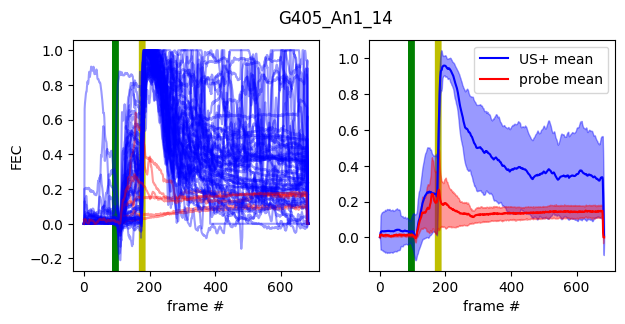

In [19]:
plot_fec(path, roi)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

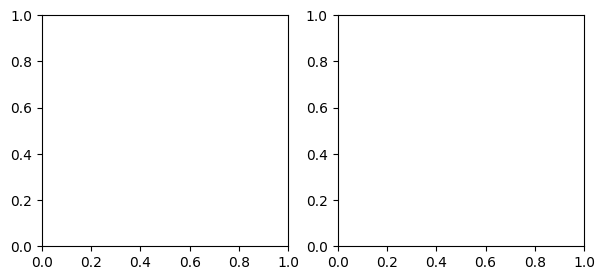

In [20]:
path = "/home1/bhalla/hrishikeshn/BehaviorRawData/G405/G405_Hr7_25"
roi = (385, 105, 415, 255)
plot_fec(path, roi)

## What next?
1. Look at Conditioned Responses
2. Test out the negated logic for white-eyed mice